In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [112]:
polyorder = 2
n = 50
i = 50
cycle = 37
x = np.array(d_trans[cycle]['sqrt_time_diff'])
y = np.array(d_trans[cycle]['Voltage/V'])
x_range = x[(i-n):(i+n)]
y_range = y[(i-n):(i+n)]
coeffs = np.polyfit(x_range, y_range, polyorder)

In [114]:
data = pd.DataFrame()

In [113]:
coeffs

array([-2.29032355e-04,  1.16517376e-02,  4.07159840e-01])

In [120]:
len(coeffs)

3

In [123]:
coeff_matrix = np.zeros((len(coeffs), len(x)))

In [128]:
coeff_matrix[:,0] = coeffs

In [129]:
coeff_matrix

array([[-2.29032355e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.16517376e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.07159840e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [116]:
data['coefs']

0   -0.000229
1    0.011652
2    0.407160
Name: coefs, dtype: float64

In [139]:
step_size = 1
len(range(n,int(len(x)),step_size))

1147

In [147]:
polyorder = 2

In [149]:
((polyorder) + 1)

3

In [150]:
def polynomial_filter(x, y, window,step_size, polyorder):
    n = window//2
    x_data = []
    y_data = []
    y_model = []
    dy_model = []
    d2y_model = []
    rmse = []
    coeff_matrix = np.zeros(
        (
            int((polyorder + 1)), len(range(n,int(len(x)),step_size))
        )
    )
    idx = 0
                            
    for i in range(n,int(len(x)),step_size):
        x_range = x[(i-n):(i+n)]
        y_range = y[(i-n):(i+n)]
        coeffs = np.polyfit(x_range, y_range, polyorder)
        ffit = np.poly1d(coeffs)
        fderiv = ffit.deriv()
        fderiv2 = fderiv.deriv()
        ym = np.polyval(ffit, x_range)
        dym = np.polyval(fderiv, x_range)
        d2ym = np.polyval(fderiv2, x_range)
        coeff_matrix[:,idx] = coeffs
        idx = idx + 1
        
        if i == n:
            for ind in range(0,int(n-step_size),step_size):
                x_data.append(x_range[ind])
                y_data.append(y_range[ind])
                y_model.append(ym[ind])
                dy_model.append(dym[ind])
                d2y_model.append(d2ym[ind])
                rmse.append(np.sqrt(np.mean((ym - y_range)**2)))
        x_data.append(x_range[n])
        y_data.append(y_range[n])
        y_model.append(ym[n])
        dy_model.append(dym[n])
        d2y_model.append(d2ym[n])
        rmse.append(np.sqrt(np.mean((ym-y_range)**2)))        
        if int(len(x_range)) - i < n:
            for ind2 in range(n+step_size,int(n-step_size),step_size):
                x_data.append(x_range[ind2])
                y_data.append(y_range[ind2])
                y_model.append(ym[ind2])
                dy_model.append([dym[ind2]])
                d2y_model.append(d2ym[ind2])
                rmse.append(np.sqrt(np.mean((ym-y_range)**2)))  
        elif int(len(x_range)) - i < n - step_size:
            break

    data = pd.DataFrame()    
    data['x_data'] = pd.Series(data = x_data)
    data['y_data'] = pd.Series(data = y_data)
    data['y_model'] = pd.Series(data = y_model)
    data['dydx'] = pd.Series(data = dy_model)
    data['d2ydx2'] = pd.Series(data = d2y_model)
    data['RMSE'] = pd.Series(data = rmse)
    
    rmse_avg = np.sqrt(np.mean((data['RMSE'])**2))
    avg_error = np.mean(data['RMSE'])

    data['avg_error'] = pd.Series(data=avg_error)
    data['rmse_avg'] = pd.Series(data=rmse_avg)
    data['window'] = pd.Series(data=window)
    data['stepsize'] = pd.Series(step_size)
                
    return data, coeff_matrix

In [81]:
def moving_average(array, n):
    return_array = np.zeros(len(array))
    
    for i in range(len(array)-1):
        if i < n:
            arr = np.sum(array[0:i])/(i+1)
            return_array[i] = arr
        elif i >= n:
            arr = np.sum(array[i-n:i+n])/(2*n)
            return_array[i] = arr
        elif i > n:
            arr = np.sum(array[i:])/(len(array)-(i-1))
            return_array[i] = arr
    
    return return_array

In [3]:
gitt1 = pd.read_csv('gitt1.csv')

In [4]:
# Cleaning up Kevin's Data

time = np.zeros(len(gitt1['TestTime']))

for i in range(len(gitt1['TestTime'])):
    if '-' not in gitt1['TestTime'][i]:
        hr = float(gitt1['TestTime'][i].split(':')[0]) * 3600
        mins = float(gitt1['TestTime'][i].split(':')[1]) * 60
        sec = float(gitt1['TestTime'][i].split(':')[2])
        time[i] = hr + mins + sec
    if '-' in gitt1['TestTime'][i]:
        #print(gitt1['TestTime'][i].split('-'))
        day = float(gitt1['TestTime'][i].split('-')[0])*86400
        idx2 = gitt1['TestTime'][i].split('-')[1]
        hr = float(idx2.split(':')[0]) * 3600
        mins = float(idx2.split(':')[1]) * 60
        sec = float(idx2.split(':')[2])
        time[i] = day + hr + mins+ sec

In [5]:
gitt1['Time(s)'] = pd.Series(time)

In [6]:
time = np.array(gitt1['Time(s)'])
voltage = np.array(gitt1['Voltage/V'])
current = np.array(gitt1['Current/mA'])

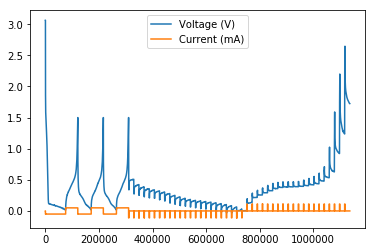

In [7]:
plt.plot(time, voltage, label = 'Voltage (V)')
plt.plot(time, current, label = 'Current (mA)')
plt.legend()
plt.show()

In [8]:
d = {}
workingcurrent = np.argwhere(current != 0)
startidx = int(workingcurrent[0])
cycle = 1

for i in range(len(workingcurrent)-1):
    if workingcurrent[i + 1] - workingcurrent[i] != 1:
        endidx = int(workingcurrent[i +1] - 1)
        d[cycle] = gitt1[startidx:endidx]
        d[cycle] = d[cycle].reset_index(drop = True)
        
        startidx = int(workingcurrent[i +1])
        cycle = cycle + 1
                       

In [9]:
d_relax = {}
dkeys = d.keys()

for key in dkeys:
    mask = d[key]['Current/mA'] == 0
    d_relax[key] = d[key][mask]
    d_relax[key] = d_relax[key].reset_index(drop = True)
    
    d_relax[key]['sqrt_time_diff'] = np.sqrt(d_relax[key]['Time(s)'] - d_relax[key]['Time(s)'][0])

In [10]:
d_trans = {}
dkeys = d.keys()

for key in dkeys:
    mask = d[key]['Current/mA'] != 0
    d_trans[key] = d[key][mask]
    d_trans[key] = d_trans[key].reset_index(drop = True)
    
    d_trans[key]['sqrt_time_diff'] = np.sqrt(d_trans[key]['Time(s)'] - d_trans[key]['Time(s)'][0])

In [11]:
d.keys() # Ignore first key, just full charge/discharge cycles

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

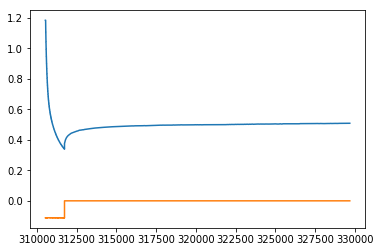

In [12]:
i = 2
plt.plot(d[i]['Time(s)'], d[i]['Voltage/V'])
plt.plot(d[i]['Time(s)'], d[i]['Current/mA'])

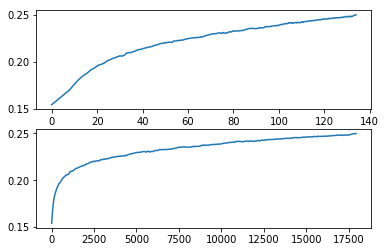

In [13]:
i = 10
fig, ax = plt.subplots(2, 1)
ax[0].plot(d_relax[i]['sqrt_time_diff'], d_relax[i]['Voltage/V'])
ax[1].plot(d_relax[i]['Time(s)']-d_relax[i]['Time(s)'][0], d_relax[i]['Voltage/V'])

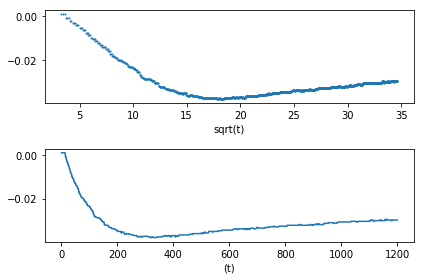

In [222]:
i = 24
fig, ax = plt.subplots(2, 1)
ax[0].plot(d_trans[i]['sqrt_time_diff'][5:], d_trans[i]['Voltage/V'][5:], 'o', markersize = 1)
ax[0].set_xlabel('sqrt(t)')

ax[1].plot(d_trans[i]['Time(s)']-d_trans[i]['Time(s)'][0], d_trans[i]['Voltage/V'])
ax[1].set_xlabel('(t)')

plt.tight_layout()

In [14]:
from scipy.signal import savgol_filter

In [19]:
E_sqrt_t_sd.head()

,x_data,y_data,y_model,dydx,d2ydx2,RMSE,avg_error,rmse_avg,window,stepsize
0,0.000000,0.47,0.468610,-0.009710,0.009770,0.001659,0.000313,0.000408,70.0,1.0
1,2.236068,0.47,0.467622,0.007173,0.005331,0.001659,NaN,NaN,NaN,NaN
2,2.449490,0.47,0.469271,0.008266,0.004908,0.001659,NaN,NaN,NaN,NaN
3,2.645751,0.47,0.470985,0.009191,0.004518,0.001659,NaN,NaN,NaN,NaN
4,2.828427,0.47,0.472738,0.009983,0.004156,0.001659,NaN,NaN,NaN,NaN


In [163]:
## This was done for the regular time data

cycle = 10
#homemade = polynomial_filter(x = np.array(d_trans[cycle]['Time(s)']), y = np.array(d_trans[cycle]['Voltage/V']), window = 70, step_size = 1, polyorder = 3)
E_sqrt_t_sd, coeff_m = polynomial_filter(x = np.array(d_trans[cycle]['sqrt_time_diff']), y = np.array(d_trans[cycle]['Voltage/V']), window = 100, step_size = 1, polyorder = 2)


Text(0.5,1,'A')

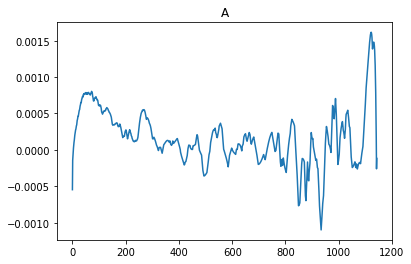

In [164]:
plt.plot(coeff_m[0,:])
plt.title('A')

Text(0.5,1,'B')

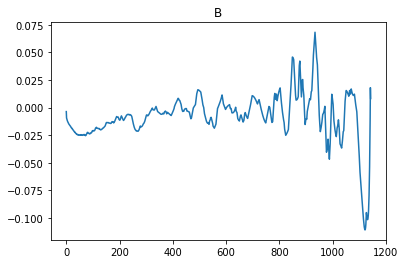

In [165]:
plt.plot(coeff_m[1,:])
plt.title('B')

Text(0.5,1,'C')

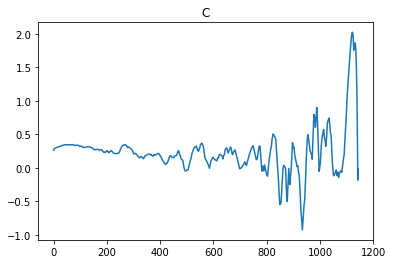

In [168]:
plt.plot(coeff_m[2,:])
plt.title('C')
#plt.ylim(-1e-1, 1e-1)

In [152]:
plt.plot(coeff_m

array([[-1.30635314e-03, -8.84919600e-04, -7.38814767e-04, ...,
        -3.04022917e-03, -4.53727077e-03, -3.83242834e-03],
       [ 3.27544088e-03, -1.30983718e-03, -2.96979599e-03, ...,
         2.09833178e-01,  3.13095262e-01,  2.64468826e-01],
       [ 2.49504614e-01,  2.61280089e-01,  2.65826641e-01, ...,
        -3.49129003e+00, -5.27196411e+00, -4.43329696e+00]])

In [156]:
window = 50
n = window // 2

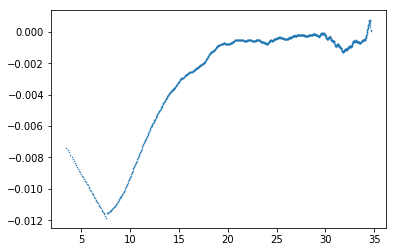

In [169]:
plt.plot(E_sqrt_t_sd['x_data'][5:], E_sqrt_t_sd['dydx'][5:], 'o', markersize = 0.5)


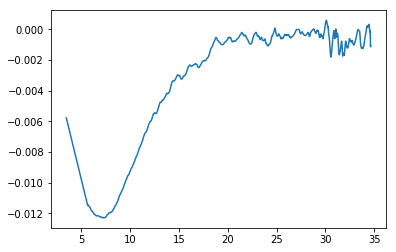

In [109]:
plt.plot(E_sqrt_t_sd['x_data'][5:], E_sqrt_t_sd['dydx'][5:])

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

` Inputs = window width, x, y, step size `

In [180]:
y_range.reshape(-1, 1)

(50, 1)

In [185]:
x = E_sqrt_t_sd['x_data']
y = E_sqrt_t_sd['dydx']
n = 25
i = 25

x_range = np.array(x[(i-n):(i+n)]).reshape(-1, 1)
y_range = np.array(y[(i-n):(i+n)]).reshape(-1, 1)

lin_model = LinearRegression()
lin_model.fit(x_range, y_range)
ypred = lin_model.predict(y_range)
lin_model.coef_

array([[-0.00109362]])

In [244]:
window = 240
n = window//2
coefs = []
mses = []
intcs = []
x = E_sqrt_t_sd['x_data']
y = E_sqrt_t_sd['y_data']
starts = []
ends = []

for i in range(n,int(len(x)-n)):
    x_range = np.array(x[(i-n):(i+n)]).reshape(-1, 1)
    y_range = np.array(y[(i-n):(i+n)]).reshape(-1, 1)
    
    lin_model = LinearRegression()
    lin_model.fit(x_range, y_range)
    y_pred = lin_model.predict(y_range)
    coef = lin_model.coef_
    intc = lin_model.intercept_
    mse = mean_squared_error(y_range, y_pred)
    startidx = int(i - n)
    endidx = int(i + n)
    
    starts.append(startidx)
    ends.append(endidx)
    coefs.append(coef.flatten()[0])
    intcs.append(intc.flatten()[0])
    mses.append(mse)
    
    
    data = pd.DataFrame()
    data['start_idx'] = pd.Series(data = starts)
    data['end_idx'] = pd.Series(data = ends)
    data['coefs'] = pd.Series(data = coefs)
    data['intcs'] = pd.Series(data = intcs)
    data['mses'] = pd.Series(data = mses)

In [258]:
data[data['mses'] == data['mses'].min()]

,start_idx,end_idx,coefs,intcs,mses
693,693,933,-0.000182,0.137919,0.000027


In [263]:
df = data
df[df['mses'] == df['mses'].min()]['end_idx']

693    933
Name: end_idx, dtype: int64

In [266]:
def index_finder(df):
    start_idx = df[df['mses'] == df['mses'].min()]['start_idx']
    end_idx = df[df['mses'] == df['mses'].min()]['end_idx']
    return start_idx, end_idx
    

In [267]:
x,y  = index_finder(data)

In [245]:
data.head()

,start_idx,end_idx,coefs,intcs,mses
0,0,240,-0.008504,0.266610,0.008985
1,1,241,-0.008558,0.267320,0.009173
2,2,242,-0.008526,0.267001,0.009177
3,3,243,-0.008489,0.266617,0.009169
4,4,244,-0.008447,0.266174,0.009150


In [246]:
data['mses'].min()

2.6977264630342277e-05

In [247]:
data.sort_values(by = 'mses')

,start_idx,end_idx,coefs,intcs,mses
693,693,933,-0.000182,0.137919,0.000027
692,692,932,-0.000184,0.137965,0.000027
694,694,934,-0.000184,0.137970,0.000028
691,691,931,-0.000185,0.138009,0.000028
695,695,935,-0.000186,0.138018,0.000028
690,690,930,-0.000187,0.138051,0.000028
689,689,929,-0.000188,0.138092,0.000029
696,696,936,-0.000187,0.138064,0.000029
688,688,928,-0.000189,0.138132,0.000029
697,697,937,-0.000189,0.138108,0.000029


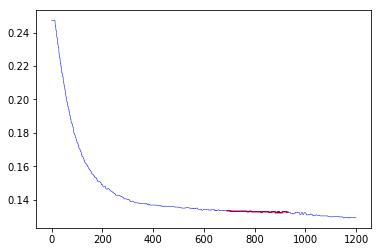

In [240]:
#x_linspace = np.linspace(E_sqrt_t_sd['x_data'][684], E_sqrt_t_sd['x_data'][924])
plt.plot(E_sqrt_t_sd['x_data'][684:924]**2, E_sqrt_t_sd['y_data'][684:924], '-', color = 'red')
plt.plot(E_sqrt_t_sd['x_data']**2, E_sqrt_t_sd['y_data'], '-', color = 'blue', lw = 0.5)
#plt.plot(x_linspace, (x_linspace*4.997592e-08)-0.000242)

In [233]:
data['coefs_squared'] = data['coefs']**2

In [234]:
data.sort_values(by = 'coefs_squared')

,start_idx,end_idx,coefs,intcs,mses,coefs_squared
684,684,924,4.997592e-08,-0.000242,6.875862e-09,2.497593e-15
905,905,1145,-3.612273e-07,-0.000765,6.277234e-08,1.304852e-13
685,685,925,-1.713511e-06,-0.000192,9.297486e-09,2.936119e-12
683,683,923,1.734388e-06,-0.000290,9.309359e-09,3.008101e-12
682,682,922,3.327778e-06,-0.000336,1.586646e-08,1.107411e-11
906,906,1146,3.497951e-06,-0.000889,7.511635e-08,1.223566e-11
686,686,926,-3.660292e-06,-0.000137,1.791816e-08,1.339774e-11
904,904,1144,-4.176288e-06,-0.000643,8.072862e-08,1.744138e-11
681,681,921,4.818160e-06,-0.000378,2.573170e-08,2.321467e-11
687,687,927,-5.884174e-06,-0.000074,3.538789e-08,3.462351e-11


In [237]:
data.sort_values(by = 'mses', ascending = False)

,start_idx,end_idx,coefs,intcs,mses,coefs_squared
49,49,289,1.082389e-03,-0.019696,2.071793e-04,1.171565e-06
51,51,291,1.075963e-03,-0.019619,2.070531e-04,1.157697e-06
52,52,292,1.072822e-03,-0.019582,2.070025e-04,1.150948e-06
50,50,290,1.078856e-03,-0.019653,2.069985e-04,1.163930e-06
48,48,288,1.084967e-03,-0.019725,2.069802e-04,1.177154e-06
53,53,293,1.069466e-03,-0.019541,2.068585e-04,1.143757e-06
54,54,294,1.065926e-03,-0.019498,2.066334e-04,1.136199e-06
47,47,287,1.087031e-03,-0.019747,2.065769e-04,1.181636e-06
55,55,295,1.062199e-03,-0.019451,2.063245e-04,1.128266e-06
46,46,286,1.088595e-03,-0.019762,2.059772e-04,1.185038e-06


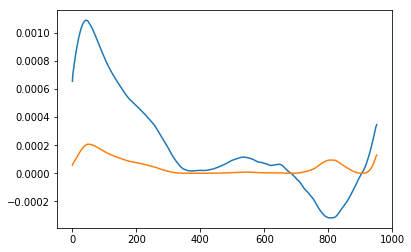

In [212]:
plt.plot(coefs)
plt.plot(mses)

In [243]:
cycle = 38


ValueError: window_length must be odd.

In [ ]:
n = window//2
x_data = []
y_data = []
y_model = []
dy_model = []
d2y_model = []
rmse = []
coeff_matrix = np.zeros(
    (
        int((polyorder + 1)), len(range(n,int(len(x)),step_size))
    )
)
idx = 0

for i in range(n,int(len(x)),step_size):
    x_range = x[(i-n):(i+n)]
    y_range = y[(i-n):(i+n)]
    coeffs = np.polyfit(x_range, y_range, polyorder)
    ffit = np.poly1d(coeffs)
    fderiv = ffit.deriv()
    fderiv2 = fderiv.deriv()
    ym = np.polyval(ffit, x_range)
    dym = np.polyval(fderiv, x_range)
    d2ym = np.polyval(fderiv2, x_range)
    coeff_matrix[:,idx] = coeffs
    idx = idx + 1

(0.003, -0.003)

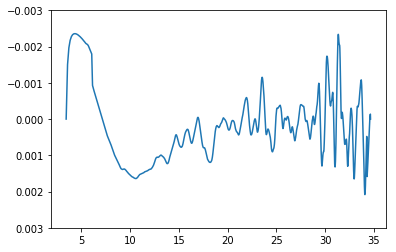

In [98]:
plt.plot(E_sqrt_t_sd['x_data'][5:], smoothed_sd)
plt.ylim(3e-3, -3e-3)

(-5e-05, 1e-05)

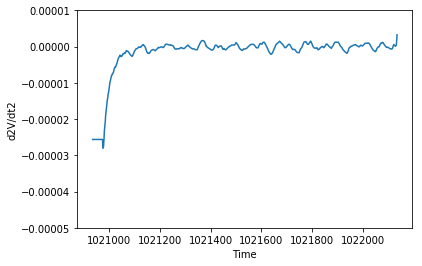

In [62]:
plt.plot(homemade['x_data'], homemade['d2ydx2'])
plt.xlabel('Time')
plt.ylabel('d2V/dt2')
plt.ylim(-5e-5,1e-5)

In [241]:
i = 39
s_filt = savgol_filter(x = d_trans[i]['Voltage/V'], window_length = 240, polyorder = 2, deriv = 1, delta = 1)
plt.plot(d_trans[i]['Time(s)'], s_filt, label = 'Python SavGol')
plt.plot(homemade['x_data'], homemade['d2ydx2'], label = 'Self-constructed SavGol')
plt.xlabel('Time')
plt.ylabel('d2V/dt2')
plt.ylim(-5e-5,1e-5)
plt.legend()

ValueError: window_length must be odd.

1194
1200.0


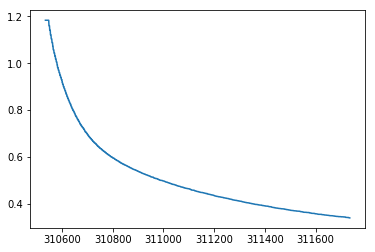

In [185]:
i = 2
plt.plot(d_trans[i]['Time(s)'], d_trans[i]['Voltage/V'])
#plt.plot(d_trans[i]['Time(s)'], d_trans[i]['Current/mA'])
print(len(d_trans[i]['Time(s)']))
print(d_trans[i]['Time(s)'][len(d_trans[i]['Time(s)'])-1] - d_trans[i]['Time(s)'][-0])